In [1]:
from common.torch_utils import get_available_device

device = get_available_device()

Platform: Darwin
Release: 21.5.0
MPS available: True
CUDA available: False
Selected device: mps


## Model

In [2]:
from fcos import FCOS
from fcos import build_backbone
from dataset import LabelsCodec

target_resolution = (256, 256)
model = FCOS(
    backbone=build_backbone('resnet50'),
    labels_codec=LabelsCodec(),
    res=target_resolution,
)

## Dataloader

In [3]:
from dataset.loader import build_dataloader

train_dataloader = build_dataloader('train', batch_size=4)
img, boxes, labels = next(iter(train_dataloader))
print(img.shape)
print(boxes)
print(labels)

torch.Size([4, 256, 256, 3])
[tensor([[  0.0000, 102.2462, 256.0000, 230.6306]]), tensor([[122.5500,  47.7867, 239.1720, 210.2613],
        [109.5920,  25.2587, 155.9680, 107.8613],
        [ 55.0320,  81.9200, 119.1400, 169.9840],
        [  0.0000,  70.3147,  78.9020, 150.1867],
        [  0.0000,  73.7280,  44.1200, 139.9467],
        [227.5780, 163.1573, 256.0000, 215.7227],
        [  0.0000, 135.1680, 256.0000, 256.0000]]), tensor([[  6.6560, 212.3093,  20.9780, 253.9520],
        [205.8000, 188.4160, 221.4860, 218.4533]]), tensor([[ 33.7344,  66.1966, 140.0256, 172.4931],
        [ 54.0777,  97.5249, 137.0588, 180.5647],
        [ 78.9671, 101.9145, 194.3590, 217.3321],
        [  0.0000,  65.8637, 232.7207, 256.0000],
        [231.0531,  86.8579, 240.6872,  96.4580]])]
[tensor([11], dtype=torch.int32), tensor([0, 0, 0, 0, 0, 2, 3], dtype=torch.int32), tensor([0, 0], dtype=torch.int32), tensor([0, 0, 0, 9, 9], dtype=torch.int32)]


/Users/iolkhovsky/Documents/repos/fcos/dataset/loader.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  return torch.Tensor(images), bboxes, labels


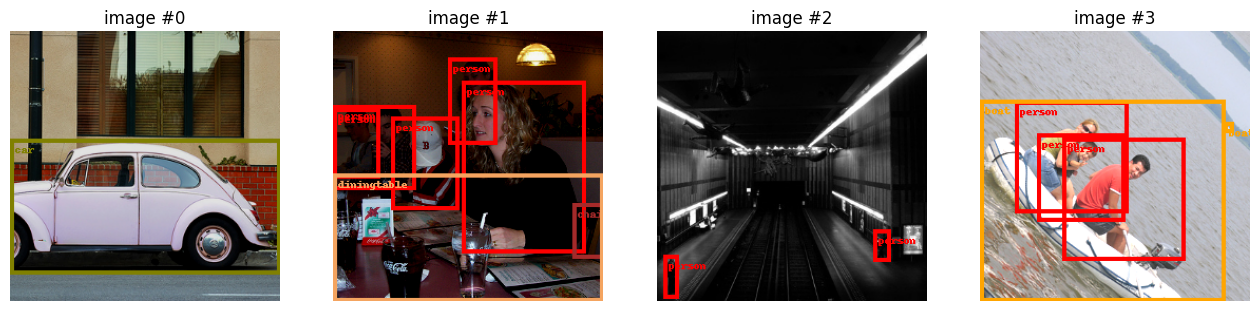

In [4]:
from dataset.visualization import visualize_batch
from dataset.labels_codec import LabelsCodec

visualize_batch(img, boxes, labels, codec=LabelsCodec())

In [5]:
pred = model(img)

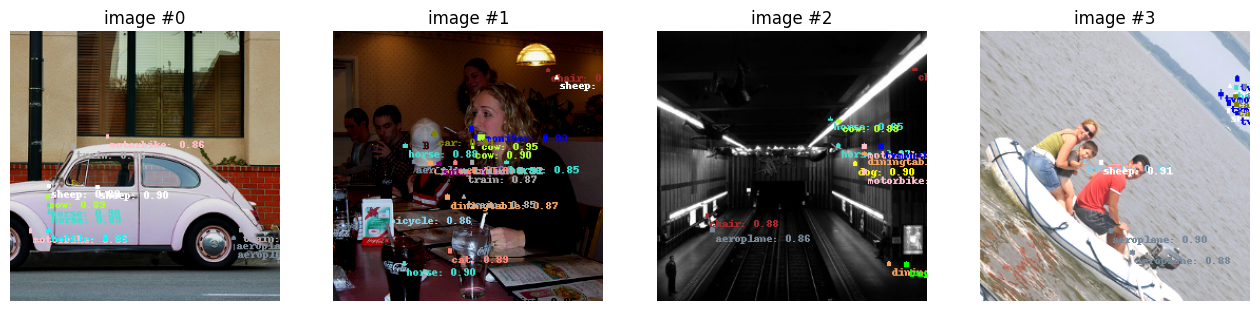

In [6]:
import torch


def draw_predictions(imgs_batch, prediction, labels_codec, threshold=0.01):  
    boxes = [[] for i in range(len(imgs_batch))]
    labels = [[] for i in range(len(imgs_batch))]
    scores = [[] for i in range(len(imgs_batch))]

    for fmap, map_pred in prediction.items():
        pred_classes = map_pred['classes']
        pred_center = map_pred['centerness']
        pred_boxes = map_pred['boxes']

        for img_idx in range(len(pred_classes)):
            img_classes = pred_classes[img_idx]
            img_centerness = pred_center[img_idx]
            img_boxes = pred_boxes[img_idx]
            
            final_scores = img_classes * img_centerness
            max_scores, max_indices = torch.max(final_scores, axis=1)
            mask = max_scores > threshold

            filtered_scores = max_scores[mask]
            filtered_labels = max_indices[mask]
            filtered_boxes = img_boxes[mask]
            
            for score, label, box in zip(filtered_scores, filtered_labels, filtered_boxes):
                scores[img_idx].append(score)
                labels[img_idx].append(label)
                boxes[img_idx].append(box)

    boxes = [
        torch.stack(img_boxes) if len(img_boxes) else torch.zeros((0, 4), dtype=torch.float)
        for img_boxes in boxes
    ]
    scores = [
        torch.stack(img_scores) if len(img_scores) else torch.zeros((0, 1), dtype=torch.float)
        for img_scores in scores
    ]  
    labels = [
        torch.stack(img_labels) if len(img_labels) else torch.zeros((0, 1), dtype=torch.float)
        for img_labels in labels
    ]

    visualize_batch(
        imgs_batch,
        boxes_batch=boxes,
        labels_batch=labels,
        scores_batch=scores,
        codec=labels_codec
    )
            


draw_predictions(img, pred, LabelsCodec(), 0.85)

## Loss function

In [7]:
from fcos import FcosDetectionsCodec
from fcos import FocalLoss, CenternessLoss, IoULoss


def total_loss(pred, target):
    # targets
    target_classes, target_centerness, target_boxes = target
    all_fmaps = list(target_classes.keys())
    
    first_map = all_fmaps[0]

    b, c, h, w = target_classes[first_map].shape
    target_classes = torch.cat(
        [
            torch.reshape(torch.permute(v, [0, 2, 3, 1]), [b, -1, c]) for k, v in target_classes.items()
        ],
        axis=1
    )

    b, c, h, w = target_centerness[first_map].shape
    target_centerness = torch.cat(
        [
            torch.reshape(torch.permute(v, [0, 2, 3, 1]), [b, -1, c]) for k, v in target_centerness.items()
        ],
        axis=1
    )

    b, c, h, w = target_boxes[first_map].shape
    target_boxes = torch.cat(
        [
            torch.reshape(torch.permute(v, [0, 2, 3, 1]), [b, -1, c]) for k, v in target_boxes.items()
        ],
        axis=1
    )

    # prediction
    pred_classes = torch.cat(
        [
            pred[map_name]['classes'] for map_name in all_fmaps
        ],
        axis=1
    )

    pred_centerness = torch.cat(
        [
            pred[map_name]['centerness'] for map_name in all_fmaps
        ],
        axis=1
    )

    pred_boxes = torch.cat(
        [
            pred[map_name]['boxes'] for map_name in all_fmaps
        ],
        axis=1
    )

    # loss
    print(f"Classes (pred / target): {pred_classes.shape} {target_classes.shape}")
    print(f"Centerness (pred / target): {pred_centerness.shape} {target_centerness.shape}")
    print(f"Boxes (pred / target): {pred_boxes.shape} {target_boxes.shape}")
    
    positive_samples = torch.sum(target_classes, axis=-1)  
    positive_mask = positive_samples > 0
    positive_samples_cnt = torch.sum(positive_mask)
    print("Positive samples cnt:", positive_samples_cnt)
    
    class_loss = FocalLoss()(
        pred_classes,
        target_classes,
    )
    class_loss = torch.mean(class_loss) / positive_samples_cnt

    centerness_loss = CenternessLoss()(
        pred_centerness,
        target_centerness,
    )
    centerness_loss = torch.mean(centerness_loss) / positive_samples_cnt

    pred_boxes_positive = torch.reshape(pred_boxes[positive_mask], [-1, 4])
    target_boxes_positive = torch.reshape(target_boxes[positive_mask], [-1, 4])

    regression_loss = IoULoss()(
        pred_boxes_positive,
        target_boxes_positive,
    )
    regression_loss = torch.mean(regression_loss)

    return class_loss, centerness_loss, regression_loss
    

img_res = (256, 256)
labels_codec = LabelsCodec()
codec = FcosDetectionsCodec(img_res, labels_codec)

targets = codec.encode(boxes, labels)
res = total_loss(pred, targets)
print("Loss", res)

/Users/iolkhovsky/Documents/repos/fcos/fcos/codec.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ltrb_tensor = torch.tensor(ltrb, dtype=torch.float32)


Classes (pred / target): torch.Size([4, 1364, 20]) torch.Size([4, 1364, 20])
Centerness (pred / target): torch.Size([4, 1364, 1]) torch.Size([4, 1364, 1])
Boxes (pred / target): torch.Size([4, 1364, 4]) torch.Size([4, 1364, 4])
Positive samples cnt: tensor(115)
Loss (tensor(0.0023, grad_fn=<DivBackward0>), tensor(nan, grad_fn=<DivBackward0>), tensor(0.8462, grad_fn=<MeanBackward0>))


## Training draft

In [8]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = total_loss

In [9]:
for epoch in range(1):

    for step, (img, boxes, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()

        pred = model(img)
        targets = codec.encode(boxes, labels)

        clf_loss, cntr_loss, regr_loss = criterion(pred, targets)
        total_loss = clf_loss + cntr_loss + regr_loss
        print(f"Step {step} Total loss: {total_loss}")
        print(f"\tClassification: {clf_loss}")
        print(f"\tCenterness {cntr_loss}")
        print(f"\tRegression {regr_loss}")
        print()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-5)
        optimizer.step()

print('Finished Training')

Classes (pred / target): torch.Size([4, 1364, 20]) torch.Size([4, 1364, 20])
Centerness (pred / target): torch.Size([4, 1364, 1]) torch.Size([4, 1364, 1])
Boxes (pred / target): torch.Size([4, 1364, 4]) torch.Size([4, 1364, 4])
Positive samples cnt: tensor(62)
Step 0 Total loss: 0.8095076084136963
	Classification: 0.004156192764639854
	Centerness 0.012676130048930645
	Regression 0.7926753163337708

Classes (pred / target): torch.Size([4, 1364, 20]) torch.Size([4, 1364, 20])
Centerness (pred / target): torch.Size([4, 1364, 1]) torch.Size([4, 1364, 1])
Boxes (pred / target): torch.Size([4, 1364, 4]) torch.Size([4, 1364, 4])
Positive samples cnt: tensor(57)
Step 1 Total loss: 0.6597679853439331
	Classification: 0.004512007348239422
	Centerness 0.014087775722146034
	Regression 0.6411681771278381

Classes (pred / target): torch.Size([4, 1364, 20]) torch.Size([4, 1364, 20])
Centerness (pred / target): torch.Size([4, 1364, 1]) torch.Size([4, 1364, 1])
Boxes (pred / target): torch.Size([4, 136

RuntimeError: all elements of input should be between 0 and 1